# Constants

In [1]:
# units of density are: kilograms per meter cubed
AIR_DENSITY = 1.027
SEAWATER_DENSITY = 1025
ICEBERG_DENSITY = 917

# units of drag form coefficients are: unit-less
ICEBERG_FORM_DRAG_COEFFICIENT_IN_AIR = 1.5
ICEBERG_FORM_DRAG_COEFFICIENT_IN_WATER = 1.5
ICEBERG_SKIN_DRAG_COEFFICIENT_IN_AIR = 2.5e-4
ICEBERG_SKIN_DRAG_COEFFICIENT_IN_WATER = 5e-4

EARTH_ROTATION_RATE = 7.2921e-5  # radians per second
EARTH_RADIUS = 6378e3  # meters

# Iceberg

In [42]:
"""Creates iceberg object."""

import numpy as np

WATERLINE_LENGTH_RANGE_BY_SIZE = {'LG': (120, 200)}
SAIL_HEIGHT_RANGE_BY_SIZE = {'LG': (45, 75)}
HEIGHT_TO_DRAFT_RATIO_BY_SHAPE = {'TAB': 0.2}
SHAPE_FACTOR_BY_SHAPE = {'TAB': 0.5}

EARTH_RADIUS = 6371e3  # meters


class Position:

    def __init__(self, latitude, longitude):
        self._latitude = latitude
        self._longitude = longitude
        self._x = 0
        self._y = 0

    @property
    def latitude(self):
        return self._latitude

    @latitude.setter
    def latitude(self, value):
        #dlat = value - self._latitude
        #self._y += dlat_to_dy(dlat)
        self._latitude = value

    @property
    def longitude(self):
        return self._longitude

    @longitude.setter
    def longitude(self, value):
        #dlon = value - self._longitude
        #lat = self._latitude
        #self._x += dlon_to_dx(dlon, lat)
        self._longitude = value

    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, value):
        #dx = value - self._x
        #lat = self._latitude
        #self._longitude += dx_to_dlon(dx, lat)
        self._x = value

    @property
    def y(self):
        return self._y

    @y.setter
    def y(self, value):
        #dy = value - self._y
        #self._latitude += dy_to_dlat(dy)
        self._y = value


class Velocity:

    def __init__(self, vx, vy):
        self.x = vx
        self.y = vy


class IcebergGeometry:

    def __init__(self, size, shape):
        self.size = size
        self.shape = shape

    @property
    def waterline_length(self):
        """Return the mean waterline length for the size declared."""
        return np.mean(WATERLINE_LENGTH_RANGE_BY_SIZE[self.size])

    @property
    def sail_height(self):
        """Return the mean sail height for the size declared."""
        return np.mean(SAIL_HEIGHT_RANGE_BY_SIZE[self.size])

    @property
    def sail_area(self):
        """Return the area of rectangular sail."""
        return self.waterline_length * self.sail_height

    @property
    def height_to_draft_ratio(self):
        """Return the height to draft ratio for the shape declared."""
        return HEIGHT_TO_DRAFT_RATIO_BY_SHAPE[self.shape]

    @property
    def shape_factor(self):
        """Return the shape factor for the shape declared."""
        return SHAPE_FACTOR_BY_SHAPE[self.shape]

    @property
    def keel_depth(self):
        """Return the keel depth for the shape and sail height declared."""
        h2d_ratio = HEIGHT_TO_DRAFT_RATIO_BY_SHAPE[self.shape]
        sail_height = self.sail_height
        return sail_height / h2d_ratio

    @property
    def mass(self):
        """Return the mass using formula from Rudkin, 2005."""
        factor = self.shape_factor
        length = self.waterline_length
        height = self.sail_height
        return 7.12e3 * factor * length ** 2 * height

    @property
    def keel_area(self):
        """Return the rectangular keel area."""
        return self.waterline_length * self.keel_depth


class Iceberg:
    """Creates iceberg object."""

    def __init__(self, time, position, velocity, geometry, **kwargs):

        self.time = time
        self.latitude, self.longitude = position
        self.eastward_velocity, self.northward_velocity = velocity
        self.geometry = geometry
        self.name = kwargs.get('name', None)
        self.history = {'time': [], 'latitude': [], 'longitude': []}
        
    def update_history(self):
        self.history['time'].append(self.time)
        self.history['latitude'].append(self.latitude)
        self.history['longitude'].append(self.longitude)
        
    
def quickstart(time, position, **kwargs):
    # position must be tuple of (latitude, longitude)
    velocity = kwargs.get('velocity', (0, 0))
    size = kwargs.get('size', 'LG')
    shape = kwargs.get('shape', 'TAB')
    geometry = IcebergGeometry(size, shape)
    iceberg = Iceberg(time, position, velocity, geometry)
    return iceberg
    
    
def old_quickstart(time, latitude, longitude, **kwargs):

    velocity = kwargs.get('velocity', (0, 0))
    velocity = Velocity(velocity[0], velocity[1])
    size = kwargs.get('size', 'LG')
    shape = kwargs.get('shape', 'TAB')

    geometry = IcebergGeometry(size, shape)
    position = Position(latitude, longitude)
    iceberg = Iceberg(time, position, velocity, geometry)

    return iceberg

def dx_to_dlon(dx, lat):
    return dx / (np.cos((lat * np.pi) / 180)) * (180 / (np.pi * EARTH_RADIUS))

def dy_to_dlat(dy):
    return dy * (180 / (np.pi * EARTH_RADIUS))

# Metocean

In [3]:
import os
import netCDF4 as nc
import xarray as xr
from urllib.request import urlretrieve
from datetime import date, timedelta


class ECMWFOcean:

    ID = "GLOBAL_ANALYSIS_FORECAST_PHY_001_024"
    PATH = 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/'
    SPATIAL_RESOLUTION = 1/12  # spatial resolution in degrees lat/lon
    TIME_RESOLUTION = 1  # temporal resolution in hours
    TIME_UNITS = 'hours since 1950-01-01 00:00:00'
    TIME_CALENDAR = 'standard'

    def __init__(self, date_bounds):

        self.dataset = xr.open_mfdataset(get_files(self.ID, self.PATH,
                                                   date_bounds))
        self.eastward_velocities = xr.DataArray(
            data=self.dataset.uo.values[:, 0, :, :],
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.latitude.values),
                    ('longitude', self.dataset.longitude.values)],
            attrs=self.dataset.uo.attrs)
        self.northward_current_velocities = xr.DataArray(
            data=self.dataset.vo.values[:, 0, :, :],
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.latitude.values),
                    ('longitude', self.dataset.longitude.values)],
            attrs=self.dataset.vo.attrs)
        self.sea_surface_temperatures = xr.DataArray(
            data=self.dataset.thetao.values[:, 0, :, :],
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.latitude.values),
                    ('longitude', self.dataset.longitude.values)],
            attrs=self.dataset.thetao.attrs)


class ECMWFAtmosphere:

    ID = "WIND_GLO_WIND_L4_NRT_OBSERVTIONS_012_004"
    PATH = 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/'
    SPATIAL_RESOLUTION = 1/4  # spatial resolution in degrees lat/lon
    TIME_RESOLUTION = 6  # temporal resolution in hours
    TIME_UNITS = 'hours since 1900-01-01 00:00:00.0 00:00'
    TIME_CALENDAR = 'standard'

    def __init__(self, date_bounds):

        self.dataset = xr.open_mfdataset(get_files(self.ID, self.PATH,
                                                   date_bounds))

        self.eastward_wind_velocities = xr.DataArray(
            data=self.dataset.eastward_wind.values,
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.latitude.values),
                    ('longitude', self.dataset.longitude.values)],
            attrs=self.dataset.eastward_wind.attrs)

        self.northward_wind_velocities = xr.DataArray(
            data=self.dataset.northward_wind.values[:, 0, :, :],
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.latitude.values),
                    ('longitude', self.dataset.longitude.values)],
            attrs=self.dataset.northward_wind.attrs)


class NARRAtmosphere:

    ID = "NCEP_North_American_Regional_Reanalysis_NARR"
    PATH = 'ftp://data.munroelab.ca/pub/NARR/atm/daily/'
    SPATIAL_RESOLUTION = 1/4  # spatial resolution in degrees lat/lon
    TIME_RESOLUTION = 3  # temporal resolution in hours
    TIME_UNITS = 'hours since 1800-1-1 00:00:0.0'
    TIME_CALENDAR = 'standard'

    def __init__(self, date_bounds):

        self.dataset = xr.open_mfdataset(get_files(self.ID, self.PATH,
                                                   date_bounds))
        self.dataset['lon'] = np.mod(self.dataset.lon - 180, 360) - 180
        self.eastward_wind_velocities = xr.DataArray(
            data=self.dataset.uwnd.values,
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.lat.values),
                    ('longitude', self.dataset.lon.values)],
            attrs=self.dataset.uwnd.attrs)
        self.northward_wind_velocities = xr.DataArray(
            data=self.dataset.vwnd.values,
            coords=[('time', self.dataset.time.values),
                    ('latitude', self.dataset.lat.values),
                    ('longitude', self.dataset.lon.values)],
            attrs=self.dataset.vwnd.attrs)


def get_files(id_, path, date_bounds, cache=True):

    start_date, end_date = date_bounds
    start_date = date(start_date.year, start_date.month, start_date.day)
    end_date = date(end_date.year, end_date.month, end_date.day)
    time_delta = end_date - start_date

    if cache:
        cache_path = 'cache/' + id_ + '/'
        if not os.path.exists(cache_path):
            try:
                os.makedirs(cache_path)
            except:
                print("Couldn't make directory for cache")
    else:
        cache_path = None

    filenames = []
    files = []

    for i in range(time_delta.days + 1):
        file_date = start_date + timedelta(days=i)
        filename = str(file_date).replace('-', '') + '.nc'
        filenames.append(filename)
        cache_file = cache_path + filename

        if os.path.isfile(cache_file):
            files.append(cache_file)
        else:
            if cache and os.path.exists(cache_path):
                files.append(urlretrieve(path +
                                         filename, cache_path + filename)[
                                 0])
            else:
                files.append(urlretrieve(path + filename)[0])

    return files

In [4]:
def interpolate(point, data):
    
    def compute_interpolation(x0, xi, dx, data):
        indx = (xi - x0) / dx
        indx_floor = int(np.floor(indx))
        dindx = indx - indx_floor
        submatrix = data[indx_floor: indx_floor + 2, ...]
        data = (1 - dindx) * submatrix[0, ...] + dindx * submatrix[1, ...]
        return data
          
    assert data.dims == ('time', 'latitude', 'longitude')
    
    # time
    nptimes = data.time.values
    times = (nptimes - nptimes[0]) / np.timedelta64(1, 's')
    t0 = times[0]
    tn = times[-1]
    dt = np.mean(np.diff((times)))
    ti = (point[0] - nptimes[0]) / np.timedelta64(1, 's')
    assert t0 <= ti <= tn
        
    # latitude
    lats = data.latitude.values
    lat0 = lats[0]
    latn = lats[-1]
    dlat = np.mean(np.diff(lats))
    lati = point[1]
    assert lat0 <= lati <= latn
    
    # longitude
    lons = data.longitude.values
    lon0 = lons[0]
    lonn = lons[-1]
    dlon = np.mean(np.diff(lons))
    loni = point[2]
    assert lon0 <= loni <= lonn
    
    # crunch value
    data = data.values
    data = compute_interpolation(t0, ti, dt, data)
    data = compute_interpolation(lat0, lati, dlat, data)
    data = compute_interpolation(lon0, loni, dlon, data)
    
    return data  

# Drift

In [5]:
def newtonian_drift(iceberg_velocity, current_velocity, wind_velocity, iceberg_constants):
    """Computes instantaneous iceberg acceleration."""

    # Constants
    Omega = EARTH_ROTATION_RATE
    rhoa = AIR_DENSITY
    rhow = SEAWATER_DENSITY
    Ca = ICEBERG_FORM_DRAG_COEFFICIENT_IN_AIR
    Cw = ICEBERG_FORM_DRAG_COEFFICIENT_IN_WATER
    Cda = ICEBERG_SKIN_DRAG_COEFFICIENT_IN_AIR
    Cdw = ICEBERG_SKIN_DRAG_COEFFICIENT_IN_WATER

    Vwx, Vwy = wind_velocity
    Vcx, Vcy = current_velocity
    #Amwx, Amwy = current_acceleration
    Amwx, Amwy = 0, 0
    
    As = iceberg_constants['sail_area']
    Ak = iceberg_constants['keel_area']
    At = iceberg_constants['top_area']
    Ab = iceberg_constants['bottom_area']
    M = iceberg_constants['mass']

    phi = iceberg_constants['latitude']

    # Args
    Vx, Vy = iceberg_velocity


    # Wind force
    Fax = (0.5 * rhoa * Ca * As + rhoa * Cda * At) * abs(Vwx - Vx) * (Vwx - Vx)
    Fay = (0.5 * rhoa * Ca * As + rhoa * Cda * At) * abs(Vwy - Vy) * (Vwy - Vy)

    # Current force
    Fwx = (0.5 * rhow * Cw * Ak + rhow * Cdw * Ab) * abs(Vcx - Vx) * (Vcx - Vx)
    Fwy = (0.5 * rhow * Cw * Ak + rhow * Cdw * Ab) * abs(Vcy - Vy) * (Vcy - Vy)

    # Coriolis force
    f = 2 * Omega * np.sin(np.deg2rad(phi))
    Fcx = f * M * Vy
    Fcy = -f * M * Vx

    # Water pressure force
    Vmwx = Vcx
    Vmwy = Vcy
    Amwx = Amwx
    Amwy = Amwy
    Fwpx = M * (Amwx + f * Vmwx)
    Fwpy = M * (Amwy - f * Vmwy)

    # Iceberg acceleration
    Ax = (Fax + Fwx + Fcx + Fwpx) / M
    Ay = (Fay + Fwy + Fcy + Fwpy) / M

    return Ax, Ay


# Beacon Data

In [6]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt

dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]

def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

def get_day_idxs(dft, day_inc = 5):

    day_idxs = []
    day_js = []
    day_j = 0
    
    for i in range(len(df)):
        day = (dft[i] - dft[0]).days
        if day == day_j:
            day_idxs.append(i)
            day_js.append(day_j)
            day_j += day_inc
    
    return day_idxs, day_js

def plot_drift_track(df, data_fname):
    
    fig = plt.figure()

    x, y = df['Longitude'], df['Latitude']
    
    plt.scatter(x, y, s=2)
    
    t = df['DataDate_UTC']
    day_idxs, day_js = get_day_idxs(t)
    
    for i, day_idx in enumerate(day_idxs):
    
        plt.text(x[day_idx], y[day_idx], str(day_js[i]), fontsize=16, )
    
    plt.title(f'Drift Track from {data_fname}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    return fig


In [7]:
csv_filenames

['0204980_2015.csv',
 '0505190_2015.csv',
 '0906790_2015.csv',
 '0907780_2015.csv']

In [8]:
filename = '0906790_2015.csv'
df = get_df(dir_path, filename)
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,90679,Solara,2015-04-24 15:21:03,NaN,51.46240,-51.55285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90679,Solara,2015-04-24 15:21:29,NaN,51.46174,-51.55156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90679,Solara,2015-04-24 15:21:57,NaN,51.46176,-51.55161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90679,Solara,2015-04-24 15:22:23,NaN,51.46177,-51.55165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90679,Solara,2015-04-24 15:22:55,NaN,51.46175,-51.55176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulate

In [10]:
from datetime import datetime

In [11]:
start_time = np.datetime64(df.DataDate_UTC.values[0])
start_datetime = datetime.utcfromtimestamp(start_time.astype(int) * 1e-9)
end_time = np.datetime64(df.DataDate_UTC.values[1000])
end_datetime = datetime.utcfromtimestamp(end_time.astype(int) * 1e-9)
start_latitude = df.Latitude.values[0]
start_longitude = df.Longitude.values[0]

dt_hours = 0.1
dt_seconds = dt_hours*3600
dt = np.timedelta64(int(dt_seconds), 's')
run_length = np.timedelta64(end_time - start_time, 's')
nt = run_length / dt

In [12]:
ocean = ECMWFOcean((start_datetime, end_datetime))
atm = NARRAtmosphere((start_datetime, end_datetime))

In [44]:
iceberg = quickstart(start_time, (start_latitude, start_longitude))

iceberg_constants = {
    'sail_area': iceberg.geometry.sail_area,
    'keel_area': iceberg.geometry.keel_area,
    'top_area': iceberg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': iceberg.geometry.mass,
    'latitude': iceberg.latitude
}

point = (iceberg.time, iceberg.latitude, iceberg.longitude)

current_velocity = (interpolate(point, ocean.eastward_velocities),
                    interpolate(point, ocean.northward_current_velocities))

wind_velocity = (interpolate(point, atm.eastward_wind_velocities),
                 interpolate(point, atm.northward_wind_velocities))

for t in range(int(nt)):
    
    ax, ay = newtonian_drift((iceberg.eastward_velocity, iceberg.northward_velocity), 
                             current_velocity, wind_velocity, 
                             iceberg_constants)
    
    iceberg.time += dt
    iceberg.eastward_velocity += ax * dt_seconds
    iceberg.northward_velocity += ay * dt_seconds
    iceberg.latitude += dy_to_dlat(iceberg.northward_velocity * dt_seconds)
    iceberg.longitude += dx_to_dlon(iceberg.eastward_velocity * dt_seconds, iceberg.latitude)
    
    point = (iceberg.time, iceberg.latitude, iceberg.longitude)
    
    current_velocity = (interpolate(point, ocean.eastward_velocities),
                       interpolate(point, ocean.northward_current_velocities))
    
    wind_velocity = (interpolate(point, atm.eastward_wind_velocities),
                    interpolate(point, atm.northward_wind_velocities))    
       
    iceberg_constants['latitude'] = iceberg.latitude
    iceberg.update_history()

In [45]:
len(iceberg.history['time']), len(iceberg.history['latitude']), len(iceberg.history['longitude']) 

(1903, 1903, 1903)

In [40]:
iceberg.eastward_velocity

-0.029467757754581103

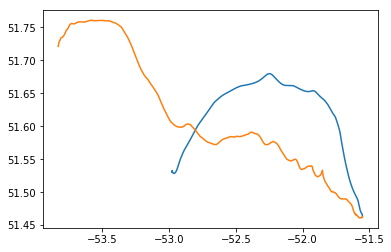

In [41]:
plt.plot(iceberg.history['longitude'], iceberg.history['latitude'])
plt.plot(df.Longitude[:1000], df.Latitude[:1000])

In [232]:
iceberg.history['longitude']

[<xarray.DataArray ()>
 array(-51.553879)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55, <xarray.DataArray ()>
 array(-51.553879)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55, <xarray.DataArray ()>
 array(-51.553879)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55, <xarray.DataArray ()>
 array(-51.553879)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55, <xarray.DataArray ()>
 array(-51.553879)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55, <xarray.DataArray ()>
 array(-51.553879)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64

In [124]:
newtonian_drift(iceberg.velocity, current_velocity, wind_velocity, iceberg_constants)

(<xarray.DataArray ()>
 array(0.006754)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55, <xarray.DataArray ()>
 array(0.006769)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55)

In [125]:
dt

NameError: name 'dt' is not defined

In [118]:
ocean_velocity

(<xarray.DataArray ()>
 array(0.043057)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55
 Attributes:
     standard_name:    eastward_sea_water_velocity
     long_name:        Eastward velocity
     units:            m s-1
     _CoordinateAxes:  time depth latitude longitude 
     unit_long:        Meters per second
     cell_methods:     area: mean, <xarray.DataArray ()>
 array(0.072634)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55
 Attributes:
     standard_name:    northward_sea_water_velocity
     long_name:        Northward velocity
     units:            m s-1
     _CoordinateAxes:  time depth latitude longitude 
     unit_long:        Meters per second
     cell_methods:     area: mean)

In [119]:
wind_velocity

(<xarray.DataArray ()>
 array(-3.239005)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55
 Attributes:
     standard_name:  eastward_wind
     long_name:      3-hourly u-wind at 10 m
     units:          m/s
     GRIB_id:        33
     GRIB_name:      UGRD
     dataset:        NARR 3-hourly
     level_desc:     10 m
     parent_stat:    Other
     statistic:      Individual Obs
     var_desc:       u-wind
     actual_range:   [-41.542862  29.228455], <xarray.DataArray ()>
 array(-0.953792)
 Coordinates:
     time       datetime64[ns] 2015-04-24T15:21:03
     latitude   float64 51.46
     longitude  float64 -51.55
 Attributes:
     standard_name:  northward_wind
     long_name:      3-hourly v-wind at 10 m
     units:          m/s
     GRIB_id:        34
     GRIB_name:      VGRD
     dataset:        NARR 3-hourly
     level_desc:     10 m
     parent_stat:    Other
     statistic:      Individual Obs
     var

In [71]:
iceberg.velocity

(0, 0)

In [25]:
ocean.data.variables

Frozen(OrderedDict([('longitude', <xarray.IndexVariable 'longitude' (longitude: 301)>
array([-65.      , -64.916664, -64.833336, ..., -40.166668, -40.083332,
       -40.      ], dtype=float32)
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X), ('latitude', <xarray.IndexVariable 'latitude' (latitude: 301)>
array([40.      , 40.083332, 40.166668, ..., 64.833336, 64.916664, 65.      ],
      dtype=float32)
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y), ('depth', <xarray.IndexVariable 'depth' (depth: 1)>
array([0.494025], dtype=float32)
Attributes:
    standard_name:           depth
    long_name:               Depth
    units:                   m
    positive:                down
    axis:                    Z
    unit_long:               Meters
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down), ('time', <xarray

In [26]:
ocean.eastward_velocities

<xarray.DataArray (time: 24, latitude: 301, longitude: 301)>
array([[[ 6.506546e-01,  5.981628e-01, ...,  3.662221e-01,  3.460799e-01],
        [ 6.463820e-01,  6.207465e-01, ...,  3.393658e-01,  3.283792e-01],
        ...,
        [ 0.000000e+00,  2.441481e-03, ..., -9.216590e-02, -1.098666e-01],
        [-6.714072e-03, -9.765923e-03, ..., -1.721244e-01, -1.751762e-01]],

       [[ 6.396680e-01,  5.829035e-01, ...,  3.631703e-01,  3.430280e-01],
        [ 6.390576e-01,  6.103702e-01, ...,  3.381451e-01,  3.265480e-01],
        ...,
        [ 6.103702e-04,  3.662221e-03, ..., -4.028443e-02, -5.432295e-02],
        [-5.493332e-03, -8.545183e-03, ..., -1.519822e-01, -1.452681e-01]],

       ...,

       [[ 7.861568e-01,  7.147435e-01, ...,  3.637806e-01,  3.344828e-01],
        [ 7.782220e-01,  7.232887e-01, ...,  3.112888e-01,  3.082370e-01],
        ...,
        [ 2.502518e-02,  2.624592e-02, ...,  2.380444e-02,  1.403851e-02],
        [ 1.953185e-02,  2.136296e-02, ...,  1.428266e-01,

In [34]:
datetimes = pd.to_datetime(ocean.data.time.values).to_pydatetime()

In [43]:
hours_since_1800 = nc.date2num(datetimes, units='hours since 1800-1-1', calendar='standard')

In [44]:
ocean.eastward_velocities['time'] = hours_since_1800

In [51]:
ocean.eastward_velocities.interp(
    time=hours_since_1800[1], latitude=start_latitude, longitude=start_longitude)

<xarray.DataArray ()>
array(0.054846)
Coordinates:
    time       float64 1.887e+06
    latitude   float64 51.46
    longitude  float64 -51.55
Attributes:
    standard_name:    eastward_sea_water_velocity
    long_name:        Eastward velocity
    units:            m s-1
    _CoordinateAxes:  time depth latitude longitude 
    unit_long:        Meters per second
    cell_methods:     area: mean

In [56]:
ocean.northward_current_velocities.interp(
time=np.datetime64('2015-04-24T00:36:00'), latitude=start_latitude, 
    longitude=start_longitude)

<xarray.DataArray ()>
array(0.091206)
Coordinates:
    time       datetime64[ns] 2015-04-24T00:36:00
    latitude   float64 51.46
    longitude  float64 -51.55
Attributes:
    standard_name:    northward_sea_water_velocity
    long_name:        Northward velocity
    units:            m s-1
    _CoordinateAxes:  time depth latitude longitude 
    unit_long:        Meters per second
    cell_methods:     area: mean

In [61]:
np.datetime64('2015-04-24T00:30:00').astype(object).year

2015

In [62]:
np.datetime64('2015-04-24T00:30:00') + np.timedelta64(6, 'm')

numpy.datetime64('2015-04-24T00:36:00')

In [63]:
datetime64 = np.datetime64('2015-04-24T00:30:00')

In [69]:
datetime64.astype(object).year

2015